- https://www.tensorflow.org/text/tutorials/image_captioning
- https://www.tensorflow.org/api_docs/python/tfm/nlp/models/TransformerDecoder
- https://keras.io/examples/vision/image_captioning


In [42]:
import sys
print(sys.executable)


c:\Users\graze\Documents\SEM-4\python\environments\deep_learning\Scripts\python.exe


In [43]:
# %pip install numpy matplotlib pandas tqdm requests scikit-image scikit-learn imutils opencv-contrib-python pillow


1. load paris dataset
2. prepare caption & vectorizer
3. build dataset
4. build visual encoder
5. build transformer decoder
6. build wrapper(encoder + decoder)
7. loss masking
8. training
9. test (inference loop)

In [44]:
# library import
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import pickle
import re, string
import keras

import os, json, time, cv2
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, ResNet50V2, resnet_v2, EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

In [45]:
# HYPERPARAMS
D_MODEL = 512
NUM_HEADS=8
DFF= 2048
NUM_LAYERS=4
MAX_CAP_LEN = 20
VOCAB_SIZE=10000
BATCH_SIZE=32
# SEQ_IMG = None
LR=1e4


In [46]:
# GPU cek
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[]


In [47]:
print(tf.__version__)

2.13.0


# 1. Load COCO2017

In [48]:
json_path = "data/coco2017/annotations/annotations/captions_train2017_subset.json"

with open(json_path, "r") as f:
  data=json.load(f)

print(data["annotations"][0].keys())

images_df = pd.DataFrame(data['images'])
annotations_df = pd.DataFrame(data['annotations'])

# gabungkan berdasarkan image_id
merged_df = annotations_df.merge(images_df, left_on='image_id', right_on='id', suffixes=('_caption', '_image'))

# tampilkan kolom penting
df = merged_df[['image_id', 'file_name', 'caption']]
print(df.head())



dict_keys(['image_id', 'id', 'caption'])
   image_id         file_name  \
0    203564  000000203564.jpg   
1    203564  000000203564.jpg   
2    203564  000000203564.jpg   
3    203564  000000203564.jpg   
4    203564  000000203564.jpg   

                                             caption  
0  A bicycle replica with a clock as the front wh...  
1                    The bike has a clock as a tire.  
2  A black metal bicycle with a clock inside the ...  
3  A bicycle figurine in which the front wheel is...  
4  A clock with the appearance of the wheel of a ...  


In [49]:
import pandas as pd
pd.DataFrame(data["annotations"]).head()


,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wh...
1,322141,49,A room with blue walls and a white sink and door.
2,16977,89,A car that seems to be parked illegally behind...
3,106140,98,A large passenger airplane flying through the ...
4,106140,101,There is a GOL plane taking off in a partly cl...


### 1. Load COCO2017

In [50]:
base_dir="./data/coco2017"

train_img_dir = os.path.join(base_dir, "images", "train2017_subset")
train_ann_path = os.path.join(base_dir, "annotations", "annotations", "captions_train2017_subset.json")

def load_coco_pairs(img_dir, ann_path):
  with open(ann_path, 'r') as f:
    ann=json.load(f)

  images ={img['id']: img['file_name'] for img in ann['images']}
  pairs=[]

  annots = ann['annotations']

  for item in annots:
    img_id = item['image_id']
    img_path = os.path.join(img_dir, images[img_id])
    caption = item['caption']

    if os.path.exists(img_path):
      # VALIDASI
      assert isinstance(img_path, str), f"img_path bukan string: {img_path}"
      assert isinstance(caption, str), f"caption bukan string: {caption}"
      pairs.append((img_path, caption))

  return pairs

# pairs = load_coco_pairs(train_img_dir, train_ann_path)
# print("tot data loaded dr local= ", len(pairs))

# if len(pairs)>0:
#   print("cth: ", pairs[:2])


In [51]:
base_dir="./data/coco2017"

# load all validation data
val_img_dir = os.path.join(base_dir, "images", "val2017", "val2017")
val_ann_path = os.path.join(base_dir, "annotations", "annotations", "captions_val2017.json")

# val_pairs = load_coco_pairs(val_img_dir, val_ann_path)

# print("tot validation loaded dr local= ", len(val_pairs))

# if len(val_pairs)>0:
#   print("cth: ", val_pairs[:2])

In [52]:
# 1. load coco pairs
train_pairs = load_coco_pairs(train_img_dir, train_ann_path)
val_pairs = load_coco_pairs(val_img_dir, val_ann_path)

### grouped load coco

In [53]:
CAP_PER_IMG=5

def load_coco_pairs_grouped(img_dir, ann_path):
    with open(ann_path, 'r') as f:
        ann = json.load(f)

    imgs_dict = {img['id']: img['file_name'] for img in ann['images']}
    captions_dict={}

    for item in ann['annotations']:
        img_id = item['image_id']
        img_path = os.path.join(img_dir, imgs_dict[img_id])
        caption = item['caption']

        if os.path.exists(img_path):
            if img_path not in captions_dict:
                captions_dict[img_path]=[]
            captions_dict[img_path].append(caption)

    unique_paths = list(captions_dict.keys())
    all_captions = list(captions_dict.values())
    
    return unique_paths, all_captions

def load_grouped_fixed(img_dir, ann_path):
    unique_paths, all_captions = load_coco_pairs_grouped(img_dir, ann_path)

    fixed_length_caps = []
    for caps_list in all_captions:
        # Potong daftar jika lebih panjang dari 5, atau tambahkan string kosong jika lebih pendek
        if len(caps_list) > CAP_PER_IMG:
            fixed_length_caps.append(caps_list[:CAP_PER_IMG])
        elif len(caps_list) < CAP_PER_IMG:
            # Padding dengan string kosong. vectorizer akan menangani ini nanti.
            padded_caps = caps_list + [''] * (CAP_PER_IMG - len(caps_list))
            fixed_length_caps.append(padded_caps)
        else:
            fixed_length_caps.append(caps_list)
            
    return unique_paths, fixed_length_caps 

train_img_paths, train_all_caps = load_grouped_fixed(train_img_dir, train_ann_path)
val_img_paths, val_all_caps = load_grouped_fixed(val_img_dir, val_ann_path)


In [54]:
# train_pairs = load_coco_pairs(train_img_dir, train_ann_path)

# for p in train_pairs[:5]:
#     print(p)
#     print(type(p[0]), type(p[1]))


In [55]:
from collections import Counter

counter = Counter([p[0] for p in train_pairs])
print(counter.most_common(5))


[('./data/coco2017\\images\\train2017_subset\\000000336464.jpg', 7), ('./data/coco2017\\images\\train2017_subset\\000000075663.jpg', 6), ('./data/coco2017\\images\\train2017_subset\\000000411564.jpg', 6), ('./data/coco2017\\images\\train2017_subset\\000000438258.jpg', 6), ('./data/coco2017\\images\\train2017_subset\\000000027065.jpg', 6)]


In [56]:
print(train_pairs[:5])
print(type(train_pairs[0][0]), type(train_pairs[0][1]))


[('./data/coco2017\\images\\train2017_subset\\000000203564.jpg', 'A bicycle replica with a clock as the front wheel.'), ('./data/coco2017\\images\\train2017_subset\\000000322141.jpg', 'A room with blue walls and a white sink and door.'), ('./data/coco2017\\images\\train2017_subset\\000000016977.jpg', 'A car that seems to be parked illegally behind a legally parked car'), ('./data/coco2017\\images\\train2017_subset\\000000106140.jpg', 'A large passenger airplane flying through the air.'), ('./data/coco2017\\images\\train2017_subset\\000000106140.jpg', 'There is a GOL plane taking off in a partly cloudy sky.')]
<class 'str'> <class 'str'>


### 2.preprocess caption & vectorizer
- vectorizer_data = vectorizer yg disave

In [57]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [58]:
def build_text_vectorizer(pairs, max_length=20):
  captions =[cap for _, cap in pairs]

  # 1. layer teks vectorizer(ubah dlm bentuk numerik)
  vectorizer = tf.keras.layers.TextVectorization(
      max_tokens = VOCAB_SIZE, # end & start
      output_sequence_length = max_length,
      standardize=standardize,
    #   pad_to_max_tokens=True #padding otomats jk output seq length diset
    #   ragged=False # ragged tensor false
  )
  # 2.adapt ke smua caption
  vectorizer.adapt(captions)

  # 3. get vocab & tambah token khusus
  vocab = vectorizer.get_vocabulary()
  special_token=['[PAD]','[UNK]', '[START]', '[END]'] # mask token, oov
  vocab = special_token + [v for v in vocab if v not in special_token]

  # 4. lookup -> bs tdk ada/gausah dipakai
  word_to_index = tf.keras.layers.StringLookup(
      vocabulary=vocab,
      mask_token="[PAD]",
      oov_token="[UNK]"
  )

  index_to_word = tf.keras.layers.StringLookup(
      vocabulary=vocab,
      mask_token="[PAD]",
      oov_token="[UNK]",
      invert=True # petakan index -> item vocab
  )

  # save vocab (utk inference)
  with open('vectorizer_data.pkl', "wb") as f:
    pickle.dump({
        "vocab":vocab,
        "max_length": max_length,
        "max_vocab_size": VOCAB_SIZE
    }, f)

  return vectorizer, word_to_index, index_to_word

In [59]:
# def build_text_vectorizer_adapt(pairs, max_length=20, max_vocab_size=5000):
#   text_ds = tf.data.Dataset.from_tensor_slices([c for _,c in pairs])
#   vectorizer = tf.keras.layers.TextVectorization(
#       max_tokens=max_vocab_size,
#       standardize=standardize,
#       output_sequence_length=max_length
#   )
#   vectorizer.adapt(text_ds)
#   return vectorizer
vectorizer, word_to_index, index_to_word=build_text_vectorizer(train_pairs)
print(vectorizer("a cat sitting on a mat"))

tf.Tensor(
[   3    2   59   15    6    2 1487    4    0    0    0    0    0    0
    0    0    0    0    0    0], shape=(20,), dtype=int64)


In [60]:
# cek masking
vec = vectorizer("a cat sitting on a mat")
print(vec)
print(vec==0)

tf.Tensor(
[   3    2   59   15    6    2 1487    4    0    0    0    0    0    0
    0    0    0    0    0    0], shape=(20,), dtype=int64)
tf.Tensor(
[False False False False False False False False  True  True  True  True
  True  True  True  True  True  True  True  True], shape=(20,), dtype=bool)


In [61]:
img_paths = [p[0] for p in train_pairs]
print(img_paths[:3])

capt=[p[1] for p in train_pairs]
print(capt[:3])

['./data/coco2017\\images\\train2017_subset\\000000203564.jpg', './data/coco2017\\images\\train2017_subset\\000000322141.jpg', './data/coco2017\\images\\train2017_subset\\000000016977.jpg']
['A bicycle replica with a clock as the front wheel.', 'A room with blue walls and a white sink and door.', 'A car that seems to be parked illegally behind a legally parked car']


### 3. Build dataset

In [62]:
# preprocess efficient net
from tensorflow.keras.applications.efficientnet import preprocess_input as efficient_preprocess

# data pipeline
def caption_to_tokens(caption, vectorizer,max_len = MAX_CAP_LEN):
    token = vectorizer(tf.expand_dims(caption, 0))[0]  # shape (seq_len,)
    
    # pad
    token = token[:max_len]  # truncate
    pad_len = max_len - tf.shape(token)[0]
    token = tf.pad(token, [[0, pad_len]])
    token = tf.cast(token, tf.int32)
    token.set_shape([max_len])  # set shape statis
    # token = tf.cast(token, tf.int32)
    return token
    
# def load_preprocess_img(pairs):
#     for img_path, cap in pairs:
#         img = tf.io.read_file(img_path)
#         img = tf.image.decode_jpeg(img, channels=3)
#         img = tf.image.resize(img, (224,224))
#         img = tf.image.convert_image_dtype(img, tf.float32)
#         # img = efficient_preprocess(img)
#         return img
        # img = tf.keras.applications.resnet.preprocess_input(img)
def preprocess_input(img_path, caption, vectorizer, max_len=MAX_CAP_LEN):
    # 1. img preprocess
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224,224))
    # img_converted = tf.image.convert_image_dtype(img, tf.float32)
    img_converted = tf.cast(img, tf.float32)/255.0

    # norm

    # 2. tokenize caption
    token = vectorizer(tf.expand_dims(caption, 0))[0]  # shape (seq_len,)

    # pad
    token = token[:max_len]  # truncate
    pad_len = max_len - tf.shape(token)[0]
    token = tf.pad(token, [[0, pad_len]])
    token = tf.cast(token, tf.int32)
    token.set_shape([max_len])  # set shape statis
    # token = tf.cast(token, tf.int32)
    dec_in=token[:-1]
    dec_out = token[1:]

    return img_converted, dec_in, dec_out

def generate_dataset(pairs, vectorizer, batch_size=BATCH_SIZE):
    img_paths = [p[0] for p in pairs]
    captions=[p[1] for p in pairs]

    dataset = tf.data.Dataset.from_tensor_slices((img_paths, captions))

    dataset = dataset.map(
        lambda ip, cap:
        preprocess_input(ip, cap, vectorizer),
        num_parallel_calls = tf.data.AUTOTUNE
    )
    # img converted, dec in, dec out

    dataset = dataset.map(lambda img, dec_in, dec_out:(
        (img, dec_in),
        dec_out
    ))

    dataset = dataset.shuffle(buffer_size=2048)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset
    # def gen():
    #         # 1. load & preprocess img
    #         img=load_preprocess_img(pairs)

    #         # teacher forcing decoder
    #         for img_path, cap in pairs:
    #             tok = caption_to_tokens(cap, vectorizer)  # (MAX_CAP_LEN,)
    #             dec_in = tok[:-1]
    #             dec_out = tok[1:]

    #             yield img, dec_in, dec_out
    #         # yield img, tok

    # output_sig = (
    #     tf.TensorSpec(shape=(224,224,3), dtype=tf.float32),
    #     tf.TensorSpec(shape=(MAX_CAP_LEN-1,), dtype=tf.int32),
    #     tf.TensorSpec(shape=(MAX_CAP_LEN-1,), dtype=tf.int32),
    # )
    # ds = tf.data.Dataset.from_generator(gen, output_signature=output_sig)


    # ds= ds.shuffle(buffer_size=2048)    
    # ds = ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    # return ds

In [63]:
# GENERATE 5 CAPT/IMG


def generate_dataset_coco(img_paths, all_caps_list, vectorizer, batch_size=BATCH_SIZE, max_len=MAX_CAP_LEN):

    dataset = tf.data.Dataset.from_tensor_slices((img_paths, all_caps_list))

    def process_and_tokenize(img_path, captions):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (224, 224))
        img = tf.cast(img, tf.float32) / 255.0 

        # Output vectorizer: (num_captions, max_len) e.g., (5, 20)
        tokenized_captions = vectorizer(captions) 
        
        # Keras expects (features, labels) for model.fit()
        # features = (image, decoder_input_sequence)
        # labels   = (target_output_sequence)

        # Di sini kita simpan sebagai (image, full_caption_sequence)
        return img, tokenized_captions
        
    dataset = dataset.shuffle(buffer_size=BATCH_SIZE*8)
    dataset = dataset.map(
        process_and_tokenize,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Panggil dataset baru ini:
train_datas = generate_dataset_coco(train_img_paths, train_all_caps, vectorizer)
val_datas = generate_dataset_coco(val_img_paths, val_all_caps, vectorizer)


In [64]:
for img, tokenized_capt in train_datas.take(1):
    print(img.shape)
    print("tokenize: ", tokenized_capt.shape)

(32, 224, 224, 3)
tokenize:  (32, 5, 20)


In [65]:
for img_batch, tokenized_capt in train_datas.take(1):
    print("img_batch : ", img_batch.shape)
    print("dtype img_batch : ", img_batch.dtype)
    print("tokenized batch shape : ", tokenized_capt.shape)
    
    print(f"Nilai min piksel dalam batch: {tf.reduce_min(img_batch).numpy()}")
    print(f"Nilai max piksel dalam batch: {tf.reduce_max(img_batch).numpy()}")


img_batch :  (32, 224, 224, 3)
dtype img_batch :  <dtype: 'float32'>
tokenized batch shape :  (32, 5, 20)
Nilai min piksel dalam batch: 0.0
Nilai max piksel dalam batch: 1.0


In [66]:
x = caption_to_tokens("a man riding a horse", vectorizer)
x.shape


TensorShape([20])

In [67]:
vectorizer, word_to_index, index_to_word=build_text_vectorizer(train_pairs, max_length=20)

train_data = generate_dataset(train_pairs,vectorizer)
val_data = generate_dataset(val_pairs,vectorizer)

In [68]:
for (img_batch, dec_in_batch), dec_out_batch in train_data.take(1):
    print("img_batch : ", img_batch.shape)
    print("dtype img_batch : ", img_batch.dtype)
    print("dec_in batch shape : ", dec_in_batch.shape)
    print("dec_out batch shape : ", dec_out_batch.shape)
    
    print(f"Nilai min piksel dalam batch: {tf.reduce_min(img_batch).numpy()}")
    print(f"Nilai max piksel dalam batch: {tf.reduce_max(img_batch).numpy()}")

    

img_batch :  (32, 224, 224, 3)
dtype img_batch :  <dtype: 'float32'>
dec_in batch shape :  (32, 19)
dec_out batch shape :  (32, 19)
Nilai min piksel dalam batch: 0.0
Nilai max piksel dalam batch: 1.0


In [69]:
# test sampel caption
sample_text = train_pairs[0][1]
tok = vectorizer(sample_text)
print("caption: ", sample_text)
print("result token vectorizer: ", tok.numpy())
print("length token: ", len(tok))

caption:  A bicycle replica with a clock as the front wheel.
result token vectorizer:  [   3    2  137 3807    9    2  162  143    5   41  544    4    0    0
    0    0    0    0    0    0]
length token:  20


In [70]:
# cek PAD (yg tdk dipelajri)
print("index PAD: ", word_to_index('[PAD]').numpy())

index PAD:  0


In [71]:
(img_b, dec_in_b),dec_out_b = next(iter(train_data))

print("img: ", img_b.shape)
print("dec_in: ", dec_in_b.shape)
print("dec_out: ", dec_out_b.shape)

print("dec_out dtype:", dec_out_b.dtype)
print("dec_out min/max:", dec_out_b.numpy().min(), dec_out_b.numpy().max())
print("unique:", tf.unique(tf.reshape(dec_out_b, [-1])).y[:20])


img:  (32, 224, 224, 3)
dec_in:  (32, 19)
dec_out:  (32, 19)
dec_out dtype: <dtype: 'int32'>
dec_out min/max: 0 9391
unique: tf.Tensor(
[   2   63   89    6 1161    7   78 1599    5 2656    4    0   86   16
    9   23   17   12  101   19], shape=(20,), dtype=int32)


### 4. Visual Encoder : pretrain ResNet50 (grid feature)

- https://keras.io/api/applications/resnet/
- https://www.tensorflow.org/text/tutorials/transformer#masking

In [72]:
def build_visual_encoder():
    base =EfficientNetB0(
        include_top=False,
        weights='imagenet') # none, h,w,c
    
    # base.trainable=trainable
    base.trainable=False # tdk include MLP model (hanya extract static)
    inp = layers.Input(shape=(224,224,3), dtype=tf.float32) # batch, height, width, channel

    # 1. preprocess
    # reshape feature map
    feat = base(inp) # shape(none, H, W, C)
    # flatten dimensi spasial -> sequence
    C =feat.shape[-1] # static
    # flatten spatial dim -> (B, H*W, C)
    seq = layers.Reshape((-1,C))(feat) # nione, H*W, C

    # projection ke dim model
    proj = layers.Dense(D_MODEL, name='proj_visual')(seq)
    model=tf.keras.Model(inputs=inp, outputs=proj, name='visual_encoder')
    return model

def create_look_ahead_mask(seq_len):
    # mask = 1-tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1,0)

        # seq_len may be a tensor scalar; ensure int32 for shapes/ops that require it
    # seq_len = tf.cast(seq_len, tf.int32)
    # matrix positions j > i are 1 (masked)
    # avoid python-int shaped tf.ones((seq_len, seq_len))
    i = tf.range(seq_len)[:, None]   # (seq_len, 1)
    j = tf.range(seq_len)[None, :]   # (1, seq_len)
    mask = tf.cast(j > i, tf.float32)* -1e9  # (seq_len, seq_len), 1. for future positions
    return mask[None, None, :, :] # shape 1,1,seqlen,seqlen
    # return mask # seq, sew


def create_padding_mask(seq): #seq=batch, seq len
    mask = tf.cast(tf.math.equal(seq,0), tf.float32) * -1e9
    return mask[:, None, None :] #batch,1,1,seq


In [73]:
# ENCODER BLOCK
# seq fitur 3D tensor, self attention,

class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim = embed_dim, dropout=0.0
        )

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2=layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation='relu')

    def call(self, inputs, training=None, mask=None):
        attn_out = self.attention_1(query=inputs, value=inputs, key=inputs, 
                                    attention_mask=None,
                                    training=training)
        skip_1 = self.layernorm_1(inputs + attn_out) # residual conn1 + norm
        dense_out = self.dense_1(skip_1) # ffn
        out_1 = self.layernorm_2(skip_1+dense_out) # residual conn 2 + norm
        return out_1

    def get_config(self):
        config=super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads":self.num_heads,
        })
        return config
    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
def build_visual_encoder_all(d_model=D_MODEL, dense_dim=256, num_heads=8):
    # 1. input layer
    inp = layers.Input(shape=(224,224,3), dtype=(tf.float32))

    # 2. base efficientnet pretrain
    base =EfficientNetB0(
        include_top=False,
        weights='imagenet') # none, h,w,c
    base.trainable=False # tdk include MLP model (hanya extract static)
    feat = base(inp) # shape(batch, Height, Weight, C)

    # 3. reshape & projeksi dense
    # flatten dimensi spasial -> sequence
    C =feat.shape[-1] # static
    # flatten spatial dim -> (B, H*W, C)
    seq = layers.Reshape((-1,C))(feat) # B, H*W, C

    # projection ke dim model
    proj = layers.Dense(d_model, name='proj_visual')(seq) #b,49,256

    # 4. encoder block (encoder layer + visual encoder)
    enc_output = TransformerEncoderBlock(
        embed_dim = d_model,
        dense_dim = dense_dim,
        num_heads = num_heads
    )(proj) # b, 49, 256

    model=tf.keras.Model(inputs=inp, outputs=enc_output, name='complete_visual_encoder')
    return model

# complete_encoder_model = build_complete_visual_encoder()


### 5. Decoder
- caption - token - embedding
- positional embedding (posisi word & konteks)
- masked self attention (jgn lihat next word)
- cross attention (caption - img fitur)
- output = logit per token

In [74]:
# DECODER
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, **kwargs):
        super(DecoderLayer, self).__init__(**kwargs)
        self.d_model = d_model
        self.num_heads=num_heads
        self.dff = dff
        self.rate = rate

        if d_model % num_heads != 0:
            raise ValueError("d_model must be divisible by num_heads")
        head_dim = d_model//num_heads
        
        # masked self attention (hanya lihat token sblmny)
        self.mha1=layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_dim)
        # encoder decoder cross attention(key=value=encoder output, query=output decoder, output global_region+bovw lihat isi gbr)
        self.mha2=layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_dim)
        
        # ffn
        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)    
        ])

        # layer norm
        self.layernorm1=layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2=layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3=layers.LayerNormalization(epsilon=1e-6)

        # dropout
        self.dropout1=layers.Dropout(rate)
        self.dropout2=layers.Dropout(rate)
        self.dropout3=layers.Dropout(rate)
    
    def call(self,x, enc_output, training, look_ahead_mask=None, padding_mask=None):
        # 1. masked self-attention
        # x=caption embeding (masking spy decoder tdk lihat next token)
        # look ahead & padding mask

        # banyak pad spy diabaikan
        # dec_padding_mask=create_padding_mask(dec_in)
        # combined_mask=tf.maximum(look_ahead_mask, dec_padding_mask)

        attn1=self.mha1(query=x,key=x,value=x, 
                        attention_mask=look_ahead_mask) # bs look ahead mask sj/combined
        attn1=self.dropout1(attn1, training=training)
        out1=self.layernorm1(x+attn1)

        # 2. encoder decoder attention / cross attention
        # enc ouput = img embedding (decoder lihat gambar lewat enc output)
        attn2=self.mha2(query=out1,  #token capt
                        key=enc_output,  #img patches
                        value=enc_output, 
                        attention_mask = None)
        attn2=self.dropout2(attn2, training=training)
        out2=self.layernorm2(out1+attn2)

        # 3. feed forward network
        ffn_output = self.ffn(out2)
        ffn_output=self.dropout3(ffn_output, training=training)
        out3=self.layernorm3(out2+ffn_output)

        return out3
    
    def get_config(self):
        config= super().get_config()
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "dff": self.dff,
            "rate":self.rate, #dropout rate
            **super().get_config()
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

# full decoder
class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, vocab_size, max_seq_len, rate=0.1, **kwargs):
        super().__init__(**kwargs)

        # token embedding (token ID -> vektor) -> positional embedding
        self.num_layers=num_layers
        self.d_model=d_model
        self.num_heads=num_heads
        self.dff=dff
        self.vocab_size=vocab_size
        self.max_seq_len=max_seq_len
        self.rate=rate

        self.embedding = layers.Embedding(vocab_size, d_model)
        self.pos_embedding = layers.Embedding(max_seq_len, d_model)

        self.dec_layers = [
            DecoderLayer(d_model, num_heads, dff, rate)
            for _ in range(num_layers)
        ]

        self.dropout = layers.Dropout(rate)

        self.final_layernorm = layers.LayerNormalization(epsilon=1e-6)
        self.final_dense = layers.Dense(vocab_size,
                                kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
                                name="final_projection")



    def call(self, x, enc_output, training, look_ahead_mask=None, 
             padding_mask=None):
        
        # batch size
        B = tf.shape(x)[0]
        # panjang token sequence
        seq_len = tf.shape(x)[1] 

        # positional embedding
        pos_indices = tf.range(seq_len, dtype=tf.int32)   # shape (seq_len,)
        pos_emb = self.pos_embedding(pos_indices)         # (seq_len, d_model)
        pos_emb = pos_emb[tf.newaxis, :, :]              # (1, seq_len, d_model)
        pos_emb = tf.tile(pos_emb, [B, 1, 1])            # (B, seq_len, d_model)
        pos_emb.set_shape([None, None, self.d_model])

        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) #  scale akar(d_model)

        x = x + pos_emb # self emb + positional emb
        x = self.dropout(x, training=training)

        # loop dgn decoder layers yg sama
        for dec_layer in self.dec_layers:
            x = dec_layer(x=x, 
                          enc_output=enc_output, 
                          training=training, 
                          look_ahead_mask=look_ahead_mask, 
                          padding_mask=padding_mask,
                           )

        # hidden state jd dist prob token
        x= self.final_layernorm(x) # normalisasi
        
        logits = self.final_dense(x) # B, seq_len, vocab_size
        return logits
    
    def get_config(self):
        config=super().get_config()
        config.update({
            "num_layers": self.num_layers,
            "d_model": self.d_model,
            "num_heads":self.num_heads,
            "dff":self.dff,
            "vocab_size": self.vocab_size,
            "max_seq_len": self.max_seq_len,
            "rate": self.rate
        })
        return config
    @classmethod
    def from_config(cls, config):
        return cls(**config)

### 6. Wrapper (encoder + decoder)

- simpan encoder(projected fitur)+ decoder
- simpan start & end token untuk test

In [75]:
# # CAPTION MODEL

class CaptioningModel(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs, training=False):
        imgs, capt_in_ids = inputs

        # 1. feature extract
        enc_output = self.encoder(imgs, training=training) #b, 49, d model

        # 2. decoder terima capt inp, output encoder
        look_ahead_mask = self.create_look_ahead_mask(capt_in_ids)

        logits=self.decoder(
            x=capt_in_ids,
            enc_output = enc_output,
            training=training,
            look_ahead_mask = look_ahead_mask
        )
        return logits

    # mask
    # def create_look_ahead_mask(self, sequence):
    #     seq_len = tf.shape(sequence)[1]
    #     look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    #     return look_ahead_mask[tf.newaxis, :, :] # dim batch
    def create_look_ahead_mask(seq_len):
        mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        look_ahead_mask = tf.cast(mask, dtype=tf.bool)
        # Tambahkan dimensi batch (B, SeqLen, SeqLen)
        return look_ahead_mask[tf.newaxis, :, :] 

    def get_config(self):
        config= super().get_config()
        config.update({
            "encoder": self.encoder,
            "decoder": self.decoder
        })
        return config

In [76]:
import inspect
print(inspect.signature(TransformerDecoder.call))


(self, x, enc_output, training, look_ahead_mask=None, padding_mask=None)


In [77]:
# visual_encoder = build_visual_encoder()
# out = visual_encoder(imgs)
# print(out.shape)


#### Wrapper

In [ ]:

def create_look_ahead_mask(seq_len):
    # tf.linalg.band_part buat matrix segitiga bawah (lower triangle matrix untuk causal masking.
    # Keras MultiHeadAttention mengharapkan mask Boolean (True untuk mask/ignore, False untuk attend)
    
    # Buat matriks segitiga atas (True di masa depan, False di masa lalu/sekarang)
    mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    
    # Ubah ke boolean (True jika > 0)
    # Keras MHA menafsirkan True sebagai nilai yang harus di-masking (diabaikan)
    look_ahead_mask = tf.cast(mask, dtype=tf.bool)

    # Tambahkan dimensi batch (B, SeqLen, SeqLen)
    return look_ahead_mask[tf.newaxis, :, :] 



class CaptionTrainer(tf.keras.Model):
    def __init__(self, vocab_size, max_seq_len, d_model, num_heads, dff, num_layers, rate=0.1, num_captions_per_image=1, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.max_seq_len = max_seq_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.num_layers = num_layers
        self.rate = rate
        self.num_captions_per_image = num_captions_per_image

        # def build_visual_encoder_all(d_model=D_MODEL, dense_dim=256, num_heads=8):

        self.encoder = build_visual_encoder_all(d_model=self.d_model)          # efficient net encoder
        self.decoder = TransformerDecoder(
                        num_layers=self.num_layers, 
                        d_model=self.d_model, 
                        num_heads=self.num_heads, 
                        dff=self.dff, 
                        vocab_size=self.vocab_size, 
                        max_seq_len=self.max_seq_len)         # Transformer decoder

        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='auto'
        )

        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")
    
    
    def call(self, inputs, training=False):
        # inputs: tuple (img, caption_inp)
        img, caption_inp = inputs
        img_embed = self.encoder(img, training=False)

        # masking decoder
        look_ahead = create_look_ahead_mask(tf.shape(caption_inp)[1])
        logits = self.decoder(caption_inp, 
                              img_embed, 
                              training=training, 
                              look_ahead_mask=look_ahead,
                              padding_mask=None) # cross attention
        return logits
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "vocab_size": self.vocab_size,
            "max_seq_len": self.max_seq_len,
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "dff": self.dff,
            "num_layers": self.num_layers,
            "rate": self.rate,
            "num_captions_per_image": self.num_captions_per_image,
            **super().get_config()
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def calculate_loss(self, y_true, y_pred, mask):
        y_true = tf.cast(y_true, tf.int32)

        loss = self.loss_fn(y_true, y_pred)  # shape (B, seq)
        loss *= tf.cast(mask, loss.dtype)

        # Cast the mask float32 (loss.dtype)
        mask_float = tf.cast(mask, loss.dtype) 
        # Pastikan pembagian tidak hasilkan NaN jika mask_float sum=0
        total_loss = tf.reduce_sum(loss)
        total_mask_elements = tf.reduce_sum(mask_float)
        
        return tf.math.divide_no_nan(total_loss, total_mask_elements)

        # return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        y_true = tf.cast(y_true, tf.int32)

        pred_ids = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
        matches = tf.equal(y_true, pred_ids)

        matches = tf.logical_and(mask, matches)
        matches = tf.cast(matches, tf.float32)
        mask = tf.cast(mask, tf.float32)

        return tf.math.divide_no_nan(tf.reduce_sum(matches), tf.reduce_sum(mask))

        # return tf.reduce_sum(matches) / tf.reduce_sum(mask)


    def compute_loss_and_acc(self, img_embed, caption_inp, caption_true, training):
        # caption_inp = caption[:, :-1]   # input tokens
        # caption_true = caption[:, 1:]   # target for loss

        # abaikan pad token
        mask = tf.not_equal(caption_true, 0)

        # 1. encode  = b, seq img, dim model (key, value pd cross attention decoder)
        # img_tokens = self.visual_encoder(imgs)
        # B = tf.shape(dec_in)[0]
        seq_len = tf.shape(caption_inp)[1]

        # 2. masking
        look_ahead = create_look_ahead_mask(seq_len)

        logits = self.decoder(
            x=caption_inp, # token
            enc_output = img_embed, # fitur img
            training=training,
            look_ahead_mask = look_ahead, #autoregressive(decoder tdk lihat nextnya)
            padding_mask = None #pad token jgn dipel
        )

        loss = self.calculate_loss(caption_true, logits, mask)
        acc  = self.calculate_accuracy(caption_true, logits, mask)

        return loss, acc


    def train_step(self, data):
        # (batch_img, dec_in_batch), dec_out_batch = data

        batch_img, batch_seq=data
        batch_loss = 0
        batch_acc = 0

        # 1. Encode image --(frozen)
        img_embed = self.encoder(batch_img, training=False) #b,49,dim model
        train_vars = self.decoder.trainable_variables
        
        # 2. Loop multiple captions
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                current_caption_sequence = batch_seq[:, i, :]
                
                # hitung loss & akurasi caption
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, 
                    current_caption_sequence[:, :-1], # Input
                    current_caption_sequence[:, 1:],  # Target
                    training=True
                )

                caption_inp = current_caption_sequence[:, :-1]   # Input decoder
                caption_true = current_caption_sequence[:, 1:]   # Target label

            # 3. Update loss and accuracy
            batch_loss += loss
            batch_acc += acc

            # 4. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 5. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # single caption
        # self.loss_tracker.update_state(loss)
        # self.acc_tracker.update_state(acc)

        return {
            "loss": self.loss_tracker.result(),
            "accuracy": self.acc_tracker.result()
        }

    def test_step(self, data):
        # (batch_img, dec_in_batch), dec_out_batch = data
        batch_img, batch_seq=data

        batch_loss = 0
        batch_acc = 0
        train_vars = self.decoder.trainable_variables
        
        # 2. Loop multiple captions
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                current_caption_sequence = batch_seq[:, i, :]
                
                # hitung loss & akurasi caption
                loss, acc = self._compute_caption_loss_and_acc(
                    batch_img, 
                    current_caption_sequence[:, :-1], # Input
                    current_caption_sequence[:, 1:],  # Target
                    training=True
                )

                caption_inp = current_caption_sequence[:, :-1]   # Input decoder
                caption_true = current_caption_sequence[:, 1:]   # Target label

            # 3. Update loss and accuracy
            batch_loss += loss
            batch_acc += acc

            # 4. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 5. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 6. Update the trackers (rata-rata loss dan akurasi per gambar dalam batch)
        # self.loss_tracker.update_state(batch_loss_per_image / float(self.num_captions_per_image))
        # self.acc_tracker.update_state(batch_acc_per_image / float(self.num_captions_per_image))
        # batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # single caption
        # loss, acc = self.compute_loss_and_acc(
        #     img_embed, 
        #     dec_in_batch,
        #     dec_out_batch,
        #     training=False
        # )

        # self.loss_tracker.update_state(loss)
        # self.acc_tracker.update_state(acc)

        return {
            "loss": self.loss_tracker.result(),
            "accuracy": self.acc_tracker.result()
        }

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]


In [82]:
for (img_batch, dec_in_batch), dec_out_batch in train_data.take(1):
    
    # 1. Dapatkan output encoder (yang menjadi input `enc_output` decoder)
    visual_encoder = build_visual_encoder_all() # Gunakan fungsi build_visual_encoder Anda
    encoder_output_test = visual_encoder(img_batch)
    print(f"Encoder Output Shape (Input Decoder Key/Value): {encoder_output_test.shape}")
    # Diharapkan: (B, 49, D_MODEL) misal (32, 49, 512)

    # 2. Inisialisasi Decoder Anda
    # Sesuaikan parameter ini dengan definisi class CaptionTrainer Anda
    sample_decoder = TransformerDecoder(
        num_layers=2, d_model=256, num_heads=8, dff=2048, vocab_size=VOCAB_SIZE, max_seq_len=MAX_CAP_LEN
    )

    # 3. Siapkan Masking yang diperlukan Decoder
    seq_len = tf.shape(dec_in_batch)[1]
    look_ahead_mask = create_look_ahead_mask(seq_len) # create_look_ahead_mask harus tersedia di scope ini

    # 4. Jalankan Decoder secara mandiri
    decoder_logits = sample_decoder(
        x=dec_in_batch,           # Input ID token caption
        enc_output=encoder_output_test, # Output fitur gambar
        training=False,           # Mode inference/testing
        look_ahead_mask=look_ahead_mask,
        padding_mask=None
    )

    print(f"Decoder Logits Shape (Output Final): {decoder_logits.shape}")
    print(f"Dtype Decoder Logits: {decoder_logits.dtype}")

    break


Encoder Output Shape (Input Decoder Key/Value): (32, 49, 512)
Decoder Logits Shape (Output Final): (32, 19, 10000)
Dtype Decoder Logits: <dtype: 'float32'>


### ver 2 : trainer

In [83]:
# cnn_model = get_cnn_model()
# encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
# decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
# caption_model = ImageCaptioningModel(
#     cnn_model=cnn_model,
#     encoder=encoder,
#     decoder=decoder,
#     image_aug=image_augmentation,
# )
D_MODEL = 512
EMBED_DIM = 512
NUM_HEADS=8
DFF= 2048
NUM_LAYERS=4
MAX_CAP_LEN = 20
VOCAB_SIZE=10000
BATCH_SIZE=32
# SEQ_IMG = None
LR=1e4

# FF_DIM = 512
# cnn_model = build_visual_encoder_all()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=DFF, num_heads=NUM_HEADS)
decoder = TransformerDecoder(num_layers=2, 
                             d_model=D_MODEL, 
                             num_heads=NUM_HEADS, 
                             dff=DFF, 
                             vocab_size=VOCAB_SIZE, 
                             max_seq_len=MAX_CAP_LEN)

# vocab_size, max_seq_len, d_model, num_heads, dff, num_layers, rate=0.1, num_captions_per_image=1
caption_model = CaptionTrainer(
    vocab_size=VOCAB_SIZE,
    max_seq_len=MAX_CAP_LEN,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dff=DFF,
    num_layers=NUM_LAYERS,
    rate=0.1,
    num_captions_per_image=1,
)

# caption_model.summary()

In [ ]:
# image_shape = (None, 224, 224, 3) # (Batch_size, H, W, C)
# caption_input_shape = (None, MAX_CAP_LEN - 1) # (Batch_size, Seq_Len_Input)

# caption_model.build(input_shape=[image_shape, caption_input_shape])
# for ((img_batch, dec_in_batch), dec_out_batch) in train_data.take(1):
#     _ = caption_model((img_batch, dec_in_batch)) 

# 5 caption/img
for ((img_batch, dec_in_batch), dec_out_batch) in train_data.take(1):
    _ = caption_model((img_batch, dec_in_batch)) # Memaksa model untuk build

caption_model.summary()


2025-11-25 16:31:16.695861: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "caption_trainer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ complete_visual_encoder         │ (None, 49, 512)        │     4,705,443 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_2           │ ?                      │    27,077,392 │
│ (TransformerDecoder)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,782,835 (121.24 MB)

 Trainable params: 27,733,264 (105.79 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
saving_path="./checkpoints"

print(os.path.exists(saving_path))


True


In [ ]:
# compile & callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = os.path.join(saving_path, "model_epoch{epoch:02d}.keras"),
    monitor = 'val_loss',
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,  # Mulai dengan 0.0001
    decay_steps=10000,           # Jumlah langkah (batches) sebelum rate turun
    decay_rate=0.96,             # Rate penurunan
    staircase=True               # Penurunan diskrit (setiap 10000 steps)
)

caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr_schedule)
)

In [ ]:
import tensorflow as tf

# Periksa apakah TensorFlow dibangun dengan dukungan CUDA
print(f"TensorFlow built with CUDA support: {tf.test.is_built_with_cuda()}")

# Daftar semua perangkat fisik yang tersedia
physical_devices = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(physical_devices)}")

if len(physical_devices) > 0:
    print(f"GPU Device Found: {physical_devices[0].name}")

else:
    print("No GPU devices found, using CPU or integrated graphics.")


TensorFlow built with CUDA support: True
Num GPUs Available: 1
GPU Device Found: /physical_device:GPU:0


In [ ]:
# 5. train
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0=all, 1=info, 2=warning, 3=error
tf.get_logger().setLevel('ERROR')        # logging TF ke ERROR saja


with tf.device('/GPU:0'):
    history= caption_model.fit(
        train_data,
        validation_data=val_data,
        epochs=20,
        callbacks=[early_stopping, checkpoint_callback]
    )

Epoch 1/20


I0000 00:00:1764063088.173575  396412 service.cc:146] XLA service 0x630a4480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764063088.173680  396412 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-11-25 16:31:28.497898: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-25 16:31:31.763972: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_288', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 16:31:32.114329: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_288', 16 bytes spill stores, 16 bytes spill loads

2025-11-25 16:31:32.127818: I external/loc

1561/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3165 - loss: 5.6903
Epoch 1: saving model to ./checkpoints/model_epoch01.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 138s 63ms/step - accuracy: 0.4326 - loss: 4.3959 - val_accuracy: 0.5610 - val_loss: 3.3998
Epoch 2/20
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6477 - loss: 2.7134
Epoch 2: saving model to ./checkpoints/model_epoch02.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 95s 59ms/step - accuracy: 0.7114 - loss: 2.2927 - val_accuracy: 0.7243 - val_loss: 2.2149
Epoch 3/20
1561/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7944 - loss: 1.6967
Epoch 3: saving model to ./checkpoints/model_epoch03.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 99s 62ms/step - accuracy: 0.8240 - loss: 1.4654 - val_accuracy: 0.7976 - val_loss: 1.6234
Epoch 4/20
1561/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8539 - loss: 1.2100
Epoch 4: saving model to ./checkpoints/model_epoch04.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 96s 60ms/step - accuracy

### update plot

In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


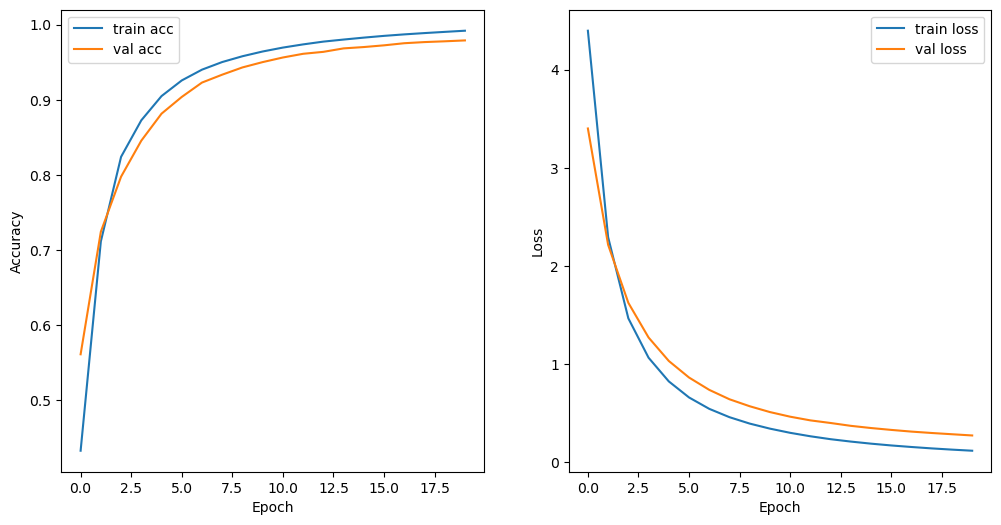

In [ ]:
# 5 epoch newest extraction
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Load model & test

In [ ]:
# 1. load model
model_path="/mnt/c/Users/graze/Documents/SEM-5/COMP-VISION/image-captioning/checkpoints/model_epoch20.keras"

print(os.path.exists(model_path))

True


In [ ]:
# loaded_model = tf.keras.models.load_model(
#     model_path,
#     custom_objects={
#         "CaptionTrainer": CaptionTrainer,
#         "TransformerDecoder": TransformerDecoder,
#         "DecoderLayer": DecoderLayer,
#         "build_visual_encoder": build_visual_encoder_all,
#     }
# )
loaded_model = tf.keras.models.load_model(
    model_path,
    custom_objects={
        # Kelas Model Utama
        "CaptionTrainer": CaptionTrainer,
        
        # Sub-kelas Kustom (Layers/Models)
        "TransformerDecoder": TransformerDecoder,
        "DecoderLayer": DecoderLayer,
        "TransformerEncoderBlock": TransformerEncoderBlock, # <-- Tambahkan ini
        
        # Fungsi Pembantu Kustom (Jika diperlukan, tergantung cara Anda mendefinisikan)
        "build_visual_encoder_all": build_visual_encoder_all, 
        "create_look_ahead_mask": create_look_ahead_mask, 
    }
)

/root/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 225 variables whereas the saved optimizer has 221 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
loaded_model.summary()

Model: "caption_trainer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ complete_visual_encoder         │ (None, 49, 512)        │     4,705,443 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_3           │ ?                      │    27,077,392 │
│ (TransformerDecoder)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,249,364 (332.83 MB)

 Trainable params: 27,733,264 (105.79 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 55,466,529 (211.59 MB)

In [ ]:
vocab = vectorizer.get_vocabulary()
# print(vocab[:8])
index_lookup = dict(zip(range(len(vocab)), vocab))
print(f"Total ukuran kosakata: {len(vocab)}")
max_decoded_sentence_length = MAX_CAP_LEN - 1

# valid_image_paths_list = list(set([item[0] for item in val_pairs]))
# print(f"Jumlah gambar validasi unik: {len(valid_image_paths_list)}")



Total ukuran kosakata: 9521


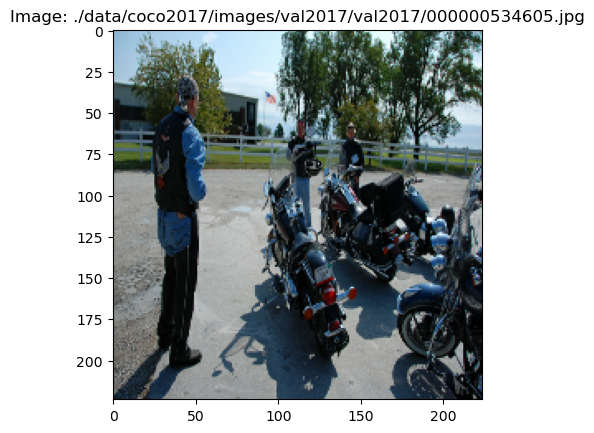

Predicted caption:  [START]


In [ ]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.cast(img, tf.float32) / 255.0 # Normalisasi
    return img
def generate_caption_keras(img_path):
    sample_img_tensor = decode_and_resize(img_path)

    img_display = sample_img_tensor.numpy().clip(0,1) * 255.0
    plt.imshow(img_display.astype(np.uint8))
    plt.title(f"Image: {img_path}")
    plt.show()

    # prepare input image (batch)
    img_inp = tf.expand_dims(sample_img_tensor, 0) # 1,224,224

    decoded_caption ="[START]"
    for i in range(MAX_CAP_LEN-1):
        tokenized_caption = vectorizer([decoded_caption])[:, :-1]

        # mask pad token
        mask = tf.math.not_equal(tokenized_caption, 0)
        
        predictions_logits = loaded_model(
            (img_inp, tokenized_caption), 
            training=False
        )
        predictions_last_token = predictions_logits[0, -1, :] # Shape: (vocab_size,)
        sampled_token_index = np.argmax(predictions_last_token)
        
        # Ubah ID menjadi kata
        sampled_token = index_lookup[sampled_token_index]

        if sampled_token=="[END]":
            break

        decoded_caption +=" "+sampled_token
    
    decoded_capt = decoded_caption.replace("[START] ", "")
    decoded_capt = decoded_caption.replace(" [END]", "").strip()
    print("Predicted caption: ", decoded_capt)

img_path = val_pairs[40][0]
generate_caption_keras(img_path)

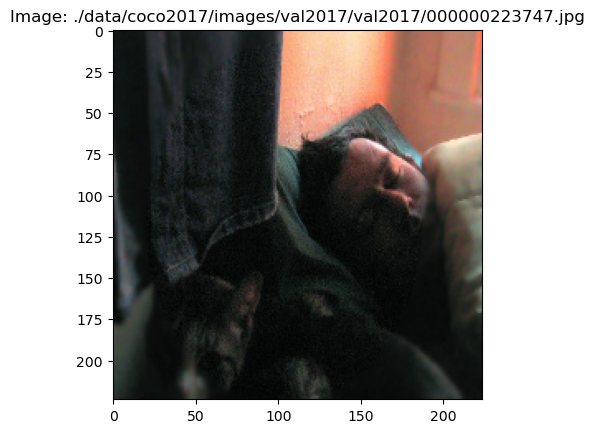

[(-0.08959515392780304, [2, 2]), (-4.2196044921875, [2, 55]), (-5.56928825378418, [2, 33])]
[(-0.38955096900463104, [2, 2, 2]), (-3.460430458188057, [2, 2, 55]), (-4.35292561352253, [2, 2, 35])]
[(-0.7392884641885757, [2, 2, 2, 2]), (-3.474107438698411, [2, 2, 55, 2]), (-3.621212527155876, [2, 2, 2, 55])]
[(-1.0182678550481796, [2, 2, 2, 2, 2]), (-3.623179927933961, [2, 2, 2, 55, 2]), (-3.680641958490014, [2, 2, 55, 2, 55])]
[(-1.2870784550905228, [2, 2, 2, 2, 2, 2]), (-4.312648788560182, [2, 2, 2, 55, 2, 55]), (-4.379718849435449, [2, 2, 55, 2, 55, 2])]
[(-1.5441215485334396, [2, 2, 2, 2, 2, 2, 2]), (-4.3555013802833855, [2, 2, 2, 55, 2, 55, 2]), (-4.40552731230855, [2, 2, 55, 2, 55, 2, 55])]
[(-1.7867965251207352, [2, 2, 2, 2, 2, 2, 2, 2]), (-4.443614330608398, [2, 2, 2, 55, 2, 55, 2, 55]), (-4.632370937615633, [2, 2, 55, 2, 55, 2, 55, 55])]
[(-1.9971218556165695, [2, 2, 2, 2, 2, 2, 2, 2, 2]), (-4.71285104425624, [2, 2, 2, 55, 2, 55, 2, 55, 2]), (-4.764968071132898, [2, 2, 55, 2, 55,

In [ ]:
def beam_search_caption_generator(img_path, index_lookup, k=3):
    start_token_id = index_lookup.get('[START]', 2)
    end_token_id = index_lookup.get('[END]', 3)

    # 1. Preprocessing gambar tunggal
    sample_img_tensor = decode_and_resize(img_path)
    img_display = sample_img_tensor.numpy().clip(0, 1) * 255.0
    plt.imshow(img_display.astype(np.uint8))
    plt.title(f"Image: {img_path}")
    plt.show()

    # Siapkan input gambar untuk model (tambahkan dimensi batch)
    img_input = tf.expand_dims(sample_img_tensor, 0) # Shape: (1, 224, 224, 3)

    # 2. Inisialisasi Beam Search
    # beams = daftar tupel: (score/log_prob, [daftar_token_id])
    beams = [(-0.0, [start_token_id])] # Mulai dengan skor 0 dan token [START]

    # 3. Loop generasi (iterasi per kata)
    for _ in range(MAX_CAP_LEN - 1):
        all_candidates = []
        for score, caption_ids in beams:
            # Lewati beam yang sudah selesai dengan [END]
            if caption_ids[-1] == end_token_id:
                all_candidates.append((score, caption_ids))
                continue

            # Konversi daftar ID ke tensor input format (1, current_seq_len)
            input_caption_ids = tf.constant([caption_ids], dtype=tf.int32)

            # Panggil model untuk prediksi kata berikutnya
            predictions_logits = caption_model(
                (img_input, input_caption_ids),
                training=False
            ) # Shape: (1, current_seq_len, vocab_size)

            # Ambil prediksi token terakhir
            predictions_last_token = predictions_logits[0, -1, :] # Shape: (vocab_size,)

            # Konversi logits menjadi log probabilitas
            token_log_probs = tf.nn.log_softmax(predictions_last_token).numpy()

            # Dapatkan indeks dan probabilitas top K untuk pencarian beam
            top_k_indices = np.argsort(token_log_probs)[-k:]

            # Buat kandidat baru dengan menambahkan kata baru ke jalur saat ini
            for index in top_k_indices:
                candidate_caption = caption_ids + [index]
                candidate_score = score + token_log_probs[index] # Perbarui skor (log probs dijumlahkan)
                all_candidates.append((candidate_score, candidate_caption))

        # Pilih K kandidat terbaik dari semua kandidat yang dihasilkan
        # Urutkan berdasarkan skor (semakin tinggi semakin baik) dan ambil top k
        all_candidates.sort(key=lambda x: x[0], reverse=True)
        beams = all_candidates[:k]
        print(beams)

        # Berhenti jika semua beam sudah selesai
        if all(beam[1][-1] == end_token_id for beam in beams):
            break

    # 4. Pilih caption terbaik (yang memiliki skor tertinggi)
    best_score, best_caption_ids = beams[0]

    # Ubah ID menjadi kalimat yang bisa dibaca
    best_caption_ids = [i for i in best_caption_ids if i not in [start_token_id, end_token_id, 0]]
    predicted_caption = " ".join([index_lookup.get(i, '[UNK]') for i in best_caption_ids]).strip()

    print("Predicted Caption (Beam Search): ", predicted_caption)

img_path = val_pairs[20][0]
beam_search_caption_generator(img_path, index_lookup, k=3)


In [ ]:
print(a)

### 7. Build-summary & train

In [ ]:
# 1.define models
visual_encoder = build_visual_encoder(d_model=D_MODEL,trainable=False)
decoder = TransformerDecoder(num_layers=2, 
                             d_model=D_MODEL, 
                             num_heads=8, 
                             dff=1280, 
                             vocab_size=VOCAB_SIZE, 
                             max_seq_len=MAX_CAP_LEN)

# dummy vectorizer
START=1
END=2
model = CaptionModel(visual_encoder, decoder, START, END)

TypeError: build_visual_encoder() got an unexpected keyword argument 'd_model'

In [ ]:
# hidden = model.decoder.call_hidden(
#     x=dec_in,
#     enc_output=enc_out,
#     training=False
# )

# tf.print("hidden max abs:", tf.reduce_max(tf.abs(hidden)))


In [ ]:
# _ = model((imgs, dec_out), training=False)   # build model

# tf.print("final_dense kernel max:",
#          tf.reduce_max(tf.abs(model.decoder.final_dense.kernel)))


In [ ]:
for (imgs, dec_in) in train_data.take(1):
    logits = model((imgs, dec_in), training=True)
    print("logits shape:", logits.shape)   # should be (B, seq_len, vocab_size)
    break


2025-11-24 21:37:12.407525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 265 of 2048
2025-11-24 21:37:32.381332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 1223 of 2048
2025-11-24 21:37:52.372973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 1990 of 2048
2025-11-24 21:37:53.762258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


logits shape: (32, 20, 5000)


In [ ]:
logits = model((imgs, dec_in), training=False)
print(tf.reduce_max(logits), tf.reduce_min(logits))


tf.Tensor(1.5377597, shape=(), dtype=float32) tf.Tensor(-1.5399746, shape=(), dtype=float32)


In [ ]:
for (imgs, toks) in train_data.take(1):
    
    # --- Tambahkan Slicing Manual di Sini ---
    # dec_in adalah semua token kecuali yang terakhir
    dec_in = toks[:, :-1]
    
    # dec_out adalah semua token kecuali yang pertama (target)
    dec_out = toks[:, 1:]
    # ----------------------------------------

    # Masukkan data ke model (sesuai dengan tanda pagar Anda)
    pred = model((imgs, dec_in), training=False)

    print("imgs shape:", imgs.shape)        # (B, 224, 224, 3)
    print("dec_in shape:", dec_in.shape)    # (B, MAX_CAP_LEN-1)
    print("dec_out shape:", dec_out.shape)  # (B, MAX_CAP_LEN-1)
    print("-" * 20)
    print("pred shape:", pred.shape)        # (B, MAX_CAP_LEN-1, vocab_size)
    print("real shape (dec_out):", dec_out.shape)
    
    break

tf.print("pred shape:", tf.shape(pred))
tf.print("pred max abs:", tf.reduce_max(tf.abs(pred)))
# cek akhir decoder input (x yang masuk final dense) — butuh mengekspose 'x' atau buat intermediate model
# cek enc_output
enc_out = visual_encoder(imgs)
tf.print("enc_out shape:", tf.shape(enc_out))
tf.print("enc_out max abs:", tf.reduce_max(tf.abs(enc_out)))
# cek embedding stats
emb = model.decoder.embedding(dec_in) * tf.math.sqrt(tf.cast(model.decoder.d_model, tf.float32))
tf.print("embedding max abs:", tf.reduce_max(tf.abs(emb)))
# cek kernel final_dense (setelah patch)
tf.print("final_dense kernel max abs:", tf.reduce_max(tf.abs(model.decoder.final_dense.kernel)))


2025-11-24 21:38:06.605415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 451 of 2048
2025-11-24 21:38:26.608582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 1362 of 2048
2025-11-24 21:38:40.156681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


imgs shape: (32, 224, 224, 3)
dec_in shape: (32, 19)
dec_out shape: (32, 19)
--------------------
pred shape: (32, 19, 5000)
real shape (dec_out): (32, 19)
pred shape: [32 19 5000]
pred max abs: 1.66723228
enc_out shape: [32 49 256]
enc_out max abs: 24.3992367
embedding max abs: 0.799991071
final_dense kernel max abs: 0.104705848


In [ ]:
# # 1. Bentuk pred dan real
# print(pred.shape, dec_out.shape)

# # 2. Cek nilai token
# print("max token id:", tf.reduce_max(dec_out))
# print("min token id:", tf.reduce_min(dec_out))

# # 3. Cek logits extreme
# print(tf.reduce_max(tf.abs(pred)))


In [ ]:
# 2. build model
dummy_img = tf.zeros((1,224,224,3)) # encode = 49 patch
dummy_capt = tf.zeros((1,MAX_CAP_LEN), dtype=tf.int32)

_ = model((dummy_img, dummy_capt), training=False)

model.summary()

Model: "caption_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ visual_encoder (Functional)     │ (None, 49, 256)        │     4,377,507 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_2           │ ?                      │     4,940,168 │
│ (TransformerDecoder)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,317,675 (35.54 MB)

 Trainable params: 5,268,104 (20.10 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# loss & metrics 
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy( from_logits=True, 
                                                         reduction='none' ) 

def masked_loss(real, pred): 
    loss = loss_obj(real, pred) 
    mask = tf.cast(tf.not_equal(real,0), loss.dtype) 
    loss *=mask 
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
saving_path="./checkpoints"

print(os.path.exists(saving_path))

# ((img_b, dec_in_b), dec_out_b) = next(iter(train_data))
# logits = model((img_b, dec_in_b), training=False)
# print(logits.shape, logits.numpy().max(), logits.numpy().min())


True


In [ ]:
# 3. callback

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-4,
#     decay_steps= 10000,# penurunan bertahap
#     decay_rate =0.96,
#     staircase=True
# )
saving_path="./checkpoints"

print(os.path.exists(saving_path))

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = os.path.join(saving_path, "model_epoch{epoch:02d}.keras"),
    monitor = 'val_loss',
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)

# callback = [early_stopping, checkpoint_callback]


In [ ]:
# 4. compile 
LR=1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(LR),
              loss=masked_loss)

In [ ]:
# tf.config.optimizer.set_jit(False)
# tf.config.run_functions_eagerly(True)
tf.config.optimizer.set_jit(False)
tf.config.run_functions_eagerly(True)

### Trainer

In [ ]:
# TRAINER
# trainer = CaptionTrainer(
#     encoder=visual_encoder,
#     decoder=decoder,
# )
D_MODEL = 256
NUM_HEADS = 8
DFF = 1280
NUM_LAYERS = 2
MAX_CAP_LEN = 20
VOCAB_SIZE = 5000

trainer = CaptionTrainer(
    vocab_size=VOCAB_SIZE,
    max_seq_len=MAX_CAP_LEN,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dff=DFF,
    num_layers=NUM_LAYERS,
    rate=0.1,
    num_captions_per_image=1,
)


# for batch_img, batch_seq in train_data.take(1):
#     trainer((batch_img, batch_seqs))

trainer.summary()

Model: "caption_trainer_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ visual_encoder (Functional)     │ (None, 49, 256)        │     4,377,507 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_7           │ ?                      │   0 (unbuilt) │
│ (TransformerDecoder)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,507 (16.70 MB)

 Trainable params: 327,936 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:

trainer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4)
)

In [ ]:
for batch_img, batch_seqs in train_data.take(1):
    enc = visual_encoder(batch_img[:1], training=False)
    print("enc shape:", enc.shape)
    print("decoder.mha2 attention_axes:", decoder.dec_layers[0].mha2.attention_axes)
    print("final_dense units:", decoder.final_dense.units)
    print("max token id in batch:", tf.reduce_max(batch_seqs).numpy())
    break


2025-11-25 00:41:47.037309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 377 of 2048
2025-11-25 00:41:57.046556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 852 of 2048
2025-11-25 00:42:07.043246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 1304 of 2048
2025-11-25 00:42:25.094040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


enc shape: (1, 49, 256)
decoder.mha2 attention_axes: None
final_dense units: 5000
max token id in batch: 4534


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = os.path.join(saving_path, "model_epoch{epoch:02d}.keras"),
    monitor = 'val_loss',
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)

In [ ]:
# def generate_caption(model: CaptionTrainer, img_path: str, index_to_word, word_to_index, max_len=20):
#     """Greedy decode single image. index_to_word: StringLookup invert layer or callable mapping id->word."""
#     img = load_and_preprocess_image(img_path)       # (224,224,3)
#     img = tf.expand_dims(img, 0)                    # (1,224,224,3)

#     enc = model.encoder(img, training=False)        # (1, Tv, D)
#     # start token
#     start_id = word_to_index(tf.constant("[START]")).numpy()
#     end_id = word_to_index(tf.constant("[END]")).numpy()
#     caption_ids = [start_id]

#     for _ in range(max_len):
#         dec_in = tf.expand_dims(caption_ids, 0)     # (1, t)
#         seq_len = dec_in.shape[1]
#         look_ahead = create_look_ahead_mask(seq_len)  # (1, t, t)
#         logits = model.decoder(dec_in, enc, training=False, look_ahead_mask=look_ahead)  # (1,t,V)
#         next_id = int(tf.argmax(logits[:, -1, :], axis=-1).numpy()[0])
#         caption_ids.append(next_id)
#         if next_id == end_id:
#             break

#     # convert ids to words
#     words = []
#     for i in caption_ids[1:]:
#         w = index_to_word(tf.constant(i)).numpy().decode('utf-8')
#         if w == "[END]":
#             break
#         words.append(w)
#     return " ".join(words)

In [ ]:
for batch_img, batch_seqs in train_data.take(1):

    batch_seqs = tf.squeeze(batch_seqs, axis=1) if len(batch_seqs.shape) == 3 else batch_seqs

    loss, acc = trainer.train_step((batch_img, batch_seqs))
    print("OK | loss:", loss, "acc:", acc)
    break


2025-11-25 00:44:47.566660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 469 of 2048
2025-11-25 00:45:07.566771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 1271 of 2048
2025-11-25 00:45:17.564952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 1747 of 2048
2025-11-25 00:45:23.976937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


OK | loss: loss acc:


In [ ]:


# 5. train
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0=all, 1=info, 2=warning, 3=error
tf.get_logger().setLevel('ERROR')        # logging TF ke ERROR saja


with tf.device('/GPU:0'):
    history= trainer.fit(
        train_data,
        validation_data=val_data,
        epochs=20,
        callbacks=[early_stopping, checkpoint_callback]
    )

Epoch 1/20


2025-11-25 00:46:01.746558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 395 of 2048
2025-11-25 00:46:21.752166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 1188 of 2048
2025-11-25 00:46:31.728060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 1703 of 2048
2025-11-25 00:46:38.732323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


      1/Unknown 49s 49s/step - accuracy: 0.0027 - loss: 8.5103

2025-11-25 00:46:41.262226: W tensorflow/core/framework/op_kernel.cc:1828] UNKNOWN: InvalidArgumentError: Exception encountered when calling TextVectorization.call().

{{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 4864 values, but the requested shape has 155648 [Op:Mul] name: 

Arguments received by TextVectorization.call():
  • inputs='a parking meter that takes visa and a car parked in the spot'
Traceback (most recent call last):

  File "/root/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/root/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/root/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 19

InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 4864 values, but the requested shape has 155648 [Op:Reshape] name: 

In [ ]:
# # RESUME
# # 1. Inisialisasi kembali trainer (strukturnya harus sama persis)
# trainer = CaptionTrainer(
#     encoder=visual_encoder,
#     decoder=decoder,
#     num_captions_per_image=5,
# )
# trainer.compile(
#     optimizer=tf.keras.optimizers.Adam(1e-4)
# )

# # 2. Cari file checkpoint terbaru
# checkpoint_dir = "./checkpoints"
# latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

# if latest_checkpoint:
#     print(f"Load weight (lastest_checkpoint): {latest_checkpoint}")
#     trainer.load_weights(latest_checkpoint)
    
#     # Ekstrak nomor epoch terakhir dari nama file (misal: model_epoch05.keras -> 5)
#     # Ini memerlukan sedikit parsing nama file
#     epoch_str = latest_checkpoint.split('_epoch')[-1].split('.')[0]
#     initial_epoch = int(epoch_str)
#     print(f"resume from init epoch: {initial_epoch + 1}")
# else:
#     print("checkpoint not found.., start from epoch 0")
#     initial_epoch = 0

# # 3. Lanjutkan pelatihan
# with tf.device('/GPU:0'):
#     history = trainer.fit(
#         train_data,
#         validation_data=val_data,
#         epochs=20,          # Epochs total yang diinginkan (misal: hingga 20)
#         initial_epoch=initial_epoch, # <-- Parameter kunci untuk resume
#         callbacks=[early_stopping, checkpoint_callback]
#     )

In [ ]:
# # 5. train
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0=all, 1=info, 2=warning, 3=error
# tf.get_logger().setLevel('ERROR')        # logging TF ke ERROR saja


# with tf.device('/GPU:0'):
#     history = model.fit(
#         train_data,
#         validation_data=val_data,
#         epochs=20,
#         callbacks=[early_stopping, checkpoint_callback],
#         steps_per_epoch = len(train_pairs) // BATCH_SIZE

#         # steps_per_epoch=5000
#     )


### 7. PLOT

In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


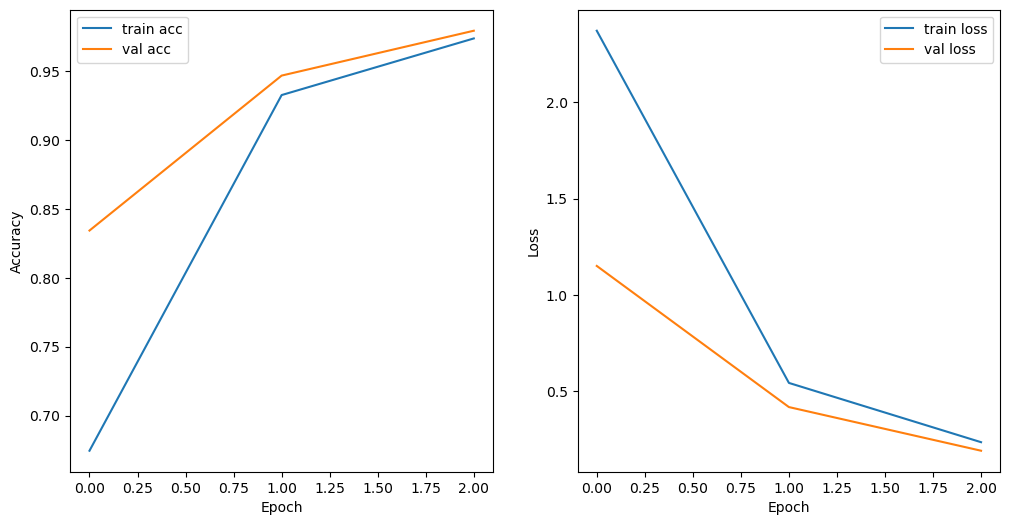

In [ ]:
# 5 epoch newest extraction
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# class VisualEncoder(tf.keras.layers.Layer):
#     def __init__(self, d_model, trainable=False, **kwargs):
#         super().__init__(**kwargs)
#         self.d_model = d_model
#         self.trainable_flag = trainable

#         self.base = EfficientNetB0(include_top=False, weights="imagenet")
#         self.base.trainable = trainable

#         self.reshape = layers.Reshape((-1, self.base.output.shape[-1]))
#         self.proj = layers.Dense(d_model)

#     def call(self, x):
#         x = self.base(x)
#         x = self.reshape(x)
#         x = self.proj(x)
#         return x

#     def get_config(self):
#         config = super().get_config()
#         config.update({
#             "d_model": self.d_model,
#             "trainable": self.trainable_flag
#         })
#         return config


### 8. Test

In [ ]:
model_path="/mnt/c/Users/graze/Documents/SEM-5/COMP-VISION/image-captioning/checkpoints/model_epoch03.keras"

print(os.path.exists(model_path))

True


In [ ]:
loaded_model = tf.keras.models.load_model(
    model_path,
    custom_objects={
        "CaptionTrainer": CaptionTrainer,
        "TransformerDecoder": TransformerDecoder,
        "DecoderLayer": DecoderLayer,
        "build_visual_encoder": build_visual_encoder,
    }
)


/root/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 118 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# dummy_img = tf.zeros((1,224,224,3))
# dummy_seq = tf.zeros((1, MAX_CAP_LEN-1), dtype=tf.int32)
# _ = loaded((dummy_img, dummy_seq), training=False)


loaded_model.summary()

Model: "caption_trainer_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ visual_encoder (Functional)     │ (None, 49, 256)        │     4,377,507 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_2           │ ?                      │   0 (unbuilt) │
│ (TransformerDecoder)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,059,939 (23.12 MB)

 Trainable params: 2,010,368 (7.67 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
def generate_caption(model: CaptionTrainer, img_path: str, index_to_word, word_to_index, max_len=20):
    """Greedy decode single image. index_to_word: StringLookup invert layer or callable mapping id->word."""
    img = load_and_preprocess_image(img_path)       # (224,224,3)
    img = tf.expand_dims(img, 0)                    # (1,224,224,3)

    enc = model.encoder(img, training=False)        # (1, Tv, D)
    # start token
    start_id = word_to_index(tf.constant("[START]")).numpy()
    end_id = word_to_index(tf.constant("[END]")).numpy()
    caption_ids = [start_id]

    for _ in range(max_len):
        dec_in = tf.expand_dims(caption_ids, 0)     # (1, t)
        seq_len = dec_in.shape[1]
        look_ahead = create_look_ahead_mask(seq_len)  # (1, t, t)
        logits = model.decoder(dec_in, enc, training=False, look_ahead_mask=look_ahead)  # (1,t,V)
        next_id = int(tf.argmax(logits[:, -1, :], axis=-1).numpy()[0])
        caption_ids.append(next_id)
        if next_id == end_id:
            break

    # convert ids to words
    words = []
    for i in caption_ids[1:]:
        w = index_to_word(tf.constant(i)).numpy().decode('utf-8')
        if w == "[END]":
            break
        words.append(w)
    return " ".join(words)


img_path = val_pairs[8][0]
caption = generate_caption(loaded_model, "img_path", index_to_word, word_to_index, max_len=20)
print(caption)


In [ ]:
# def generate_caption(model, img, index_to_word, max_len=20):
#     img = tf.image.resize(img, (224,224))
#     img = tf.expand_dims(img, 0)
#     enc = model.encoder(img, training=False)

#     seq = [word_to_index["<start>"]]

#     for _ in range(max_len):
#         inp = tf.expand_dims(seq, 0)
#         logits = model.decoder(inp, enc, training=False)
#         next_id = tf.argmax(logits[:, -1, :], axis=-1).numpy()[0]

#         seq.append(next_id)
#         if next_id == word_to_index["<end>"]:
#             break

#     return " ".join(index_to_word[i] for i in seq)



In [ ]:
img_path = val_pairs[8][0]

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = tf.cast(img, tf.float32)
    img = efficient_preprocess(img)
    return tf.expand_dims(img, 0)   # add batch dimension

def generate_caption(model, img_path, index_to_word, word_to_index, max_len=20):
    img = load_and_preprocess_image(img_path)

    # ENCODE
    img_features = model.encoder(img, training=False) # 1,49, 256
    print(img_features.shape)

    # token
    start_token = word_to_index("[START]").numpy()
    end_token = word_to_index("[END]").numpy()
    caption = [start_token]

    for _ in range(max_len):
        # dec_input = tf.expand_dims(caption, 0)
        dec_input = tf.convert_to_tensor([caption], dtype=tf.int32) #1,seq

        preds = model.decoder(x=dec_input, 
                            enc_output=img_features, 
                            training=False,
                            look_ahead_mask = create_look_ahead_mask(len(caption))
                            )
        next_id = tf.argmax(preds[:, -1, :], axis=-1).numpy()[0]
        caption.append(next_id)

        if next_id == end_token:
            break


    # Convert idx -> word
    # words = index_to_word(tf.constant(caption)).numpy()
    # words = [w.decode("utf-8") for w in words]

    # # Remove [START] and [END]
    # words = [w for w in words if w not in ["[START]", "[END]", "[PAD]"]]
    words = index_to_word(caption).numpy().astype(str)
    # words = [w for w in words if w not in ["[PAD]", "[START]", "[END]"]]
    return " ".join(words[1:-1])


In [ ]:
idx = word_to_index(tf.constant(["cat"]))
print(idx.numpy())   # contoh: [128]


[60]


In [ ]:
def generate_caption(model, img_path, index_to_word, word_to_index, max_len=20):
    img = load_and_preprocess_image(img_path)
    
    # start token id
    start_id = word_to_index(tf.constant('[START]')).numpy()
    caption = [start_id]
    # encode image
    img_embed = model.encoder(img, training=False)  # shape (1, seq_len, d_model)
    # flatten img embedding jadi seq
    img_embed = tf.reshape(img_embed, (1, -1, img_embed.shape[-1]))  # (1, 49, 256)
    print("img embed: ", img_embed.shape)

    print(img_embed.shape)
    for _ in range(max_len):
        dec_input = tf.expand_dims(caption, 0)  # (1, seq_len)
        print("dec input done..")

        seq_len = dec_input.shape[1]
        look_ahead = create_look_ahead_mask(seq_len)

        logits = model.decoder(dec_input, 
                                img_embed, 
                                training=False, 
                                look_ahead_mask = look_ahead)
        print("logits: ", logits.shape)
        next_id = tf.argmax(logits[:, -1, :], axis=-1).numpy()[0]
        caption.append(next_id)
        if next_id == word_to_index(tf.constant('[END]')).numpy():
            break
    print("caption: ", caption)

    words = [index_to_word(id).numpy().decode('utf-8') for id in caption[1:]]  # skip start
    return ' '.join(words)


In [ ]:
def rebuild_decoder_with_mha_3d(original_decoder):
    new_decoder = TransformerDecoder(
        num_layers=original_decoder.num_layers,
        d_model=original_decoder.d_model,
        num_heads=original_decoder.num_heads,
        dff=original_decoder.dff,
        vocab_size=original_decoder.vocab_size,
        max_seq_len=original_decoder.max_seq_len,
        rate=original_decoder.rate,
    )
    return new_decoder


def generate_caption(model, img_path, index_to_word, word_to_index, max_len=20):
    # 1️⃣ Load dan preprocess image
    img = load_and_preprocess_image(img_path)  # (224, 224, 3)
    print("Original image shape:", img.shape)

    # img = tf.expand_dims(img, 0)               # (1, 224, 224, 3)
    # print("After batch dim:", img.shape)

    # 2️⃣ Encode image
    img_embed = model.encoder(img, training=False)  # (1, seq_img, d_model)
    # img_embed = tf.squeeze(img_embed, axis=1)  # (1,49,256) BUKAN (1,1,49,256)

    print("Image embedding shape:", img_embed.shape)

    # 3️⃣ Siapkan caption token start & end
    start_id = word_to_index(tf.constant('[START]')).numpy()
    end_id = word_to_index(tf.constant('[END]')).numpy()
    caption = [start_id]

    # 4️⃣ Autoregressive decoding loop
    for step in range(max_len):
        # dec_input = tf.constant([caption], dtype=tf.int32)
        dec_input = tf.expand_dims(caption, 0)  # (1, seq_len)
        predictions = model.decoder(
            dec_input,
            img_embed, training=False
        )
        # 4a. Look-ahead mask
        # look_ahead_mask = create_look_ahead_mask(seq_len)
        # print("Look-ahead mask shape:", look_ahead_mask.shape)

        # 4b. Decoder prediction
        # loaded_model.decoder=rebuild_decoder_with_mha_3d(loaded_model.decoder)
        # logits = model.decoder(
        #     x=dec_input,
        #     enc_output=img_embed,
        #     training=False,
        #     look_ahead_mask=look_ahead_mask,
        #     padding_mask=None
        # )
        # print("Logits shape:", predictions.shape)

        # 4c. Pilih token berikutnya
        next_id = tf.argmax(logits[:, -1, :], axis=-1).numpy()[0]
        caption.append(next_id)
        print("Next token ID:", next_id)

        # Take last timestep
        next_token_logits = predictions[:, -1, :]
        next_id = tf.argmax(next_token_logits, axis=-1).numpy()[0]

        # # Stop at EOS
        # if next_id == end_token:
        #     break

        # Stop jika token END muncul
        if next_id == end_id:
            print("End token generated, stopping...")
            break

    # 5️⃣ Convert token IDs ke kata
    caption_words = [
        index_to_word[idx] 
        for idx in caption_seq 
        if idx not in (start_token, end_token)
    ]

    final_caption = " ".join(caption_words)
    return final_caption

    # return final_caption


img_path = val_pairs[8][0]

caption = generate_caption(
    loaded_model,
    img_path,
    index_to_word,
    word_to_index,
    max_len=20
)

print("Caption:", caption)



Original image shape: (1, 224, 224, 3)
Image embedding shape: (1, 49, 256)


ValueError: Exception encountered when calling MultiHeadAttention.call().

[1mInput 0 of layer "key" is incompatible with the layer: expected ndim=5, found ndim=3. Full shape received: (1, 49, 256)[0m

Arguments received by MultiHeadAttention.call():
  • query=tf.Tensor(shape=(1, 1, 256), dtype=float32)
  • value=tf.Tensor(shape=(1, 49, 256), dtype=float32)
  • key=tf.Tensor(shape=(1, 49, 256), dtype=float32)
  • query_mask=None
  • value_mask=None
  • key_mask=None
  • attention_mask=None
  • return_attention_scores=False
  • training=False
  • use_causal_mask=False

In [ ]:
# contoh load
# loaded_model = tf.keras.models.load_model("model_epoch10.keras", custom_objects={
#     "CaptionModel": CaptionModel,
#     "TransformerDecoder": TransformerDecoder,
#     "DecoderLayer": DecoderLayer,
#     "masked_loss": masked_loss
# })


In [ ]:
# def generate_caption(model, image, start_token, end_token, max_len=MAX_CAP_LEN):
#     caption = [start_token]

#     for _ in range(max_len):
#         cap_tensor = tf.expand_dims(caption, 0)  # (1, seq_len)
        
#         pred = model((image, cap_tensor), training=False)
#         pred_id = tf.argmax(pred[:, -1, :], axis=-1).numpy()[0]

#         caption.append(pred_id)

#         if pred_id == end_token:
#             break

#     return caption

# img = load_and_preprocess("test_image.jpg")  # bentuk (1, 224, 224, 3)

# generated_ids = generate_caption(model, img, START, END)
# generated_caption = vectorizer.decode(generated_ids)
# print("Caption:", generated_caption)


### OLD

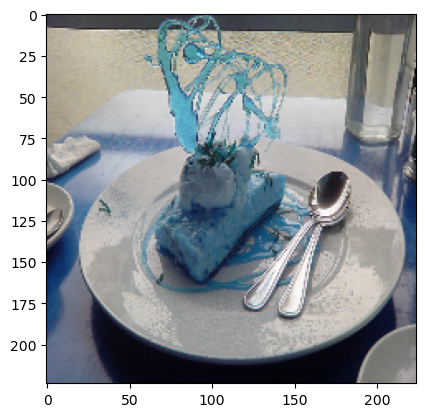

In [ ]:
# img_path = val_pairs[8][0]

# img = cv2.imread(img_path)
# img = cv2.resize(img, (224,224))
# plt.imshow(img)


In [ ]:
# vocab = vectorizer.get_vocabulary()
# index_lookup = dict(zip(range(len(vocab)), vocab))
# max_decoded_sentence_length = 20

# for i, val in index_lookup.items():
#     print(i," = " ,val)

0  =  
1  =  [UNK]
2  =  a
3  =  [START]
4  =  [END]
5  =  the
6  =  on
7  =  of
8  =  in
9  =  with
10  =  and
11  =  is
12  =  to
13  =  street
14  =  an
15  =  sitting
16  =  bathroom
17  =  next
18  =  white
19  =  man
20  =  two
21  =  train
22  =  at
23  =  toilet
24  =  standing
25  =  are
26  =  people
27  =  sign
28  =  bus
29  =  kitchen
30  =  parked
31  =  that
32  =  large
33  =  it
34  =  motorcycle
35  =  small
36  =  red
37  =  sink
38  =  down
39  =  near
40  =  bench
41  =  front
42  =  woman
43  =  some
44  =  giraffe
45  =  by
46  =  black
47  =  city
48  =  road
49  =  building
50  =  blue
51  =  up
52  =  top
53  =  has
54  =  side
55  =  green
56  =  riding
57  =  group
58  =  car
59  =  cat
60  =  field
61  =  sheep
62  =  stop
63  =  person
64  =  water
65  =  bird
66  =  traffic
67  =  airplane
68  =  there
69  =  fire
70  =  walking
71  =  flying
72  =  light
73  =  dog
74  =  plane
75  =  hydrant
76  =  room
77  =  yellow
78  =  grass
79  =  over
80  =  from

In [ ]:
vocab = vectorizer.get_vocabulary()
print("[START] in vocab?", "[START]" in vocab)
print("[END] in vocab?", "[END]" in vocab)

start_id = vectorizer(["[START]"])[0,0].numpy()
print("Start token id:", start_id)


[START] in vocab? True
[END] in vocab? True
Start token id: 3


=== DEBUG INFO ===
Raw patch_emb shape: (49, 128)
Raw region_emb shape: (20, 128)
caption_model: <class '__main__.CaptionTransformer'>
caption_model.visual_encoder: <class '__main__.VisualEncoder'>


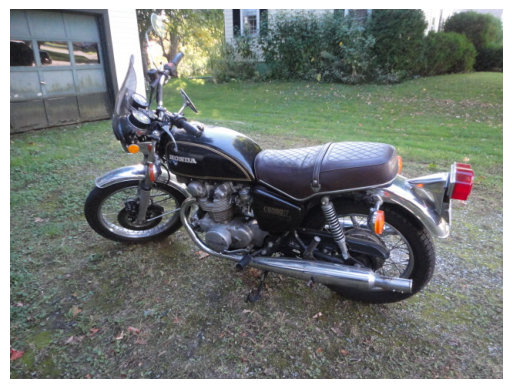

Generated Caption: has roads steadily screen gallon cozy transport talk directly pet combination lonely stairwell octopus satchel style tethered parent radiate trashcan


In [ ]:
img_path = val_pairs[0][0]

generated_capt = generate_caption(
    caption_model=loaded_model,
    img_path=img_path,
    vectorizer=vectorizer,
    index_lookup=index_lookup,
)

In [ ]:
img_path = val_pairs[11][0]

patch_emb, region_emb, _ = extract_manual_features(img_path)
print("patch_emb min/max:", patch_emb.min(), patch_emb.max())
print("region_emb min/max:", region_emb.min(), region_emb.max())

# patch_emb min/max: 8.567568 94.545944
# region_emb min/max: 0.0 169.0

patch_emb min/max: 7.5067263 109.13004
region_emb min/max: 0.0 176.71428


In [ ]:
# sample_img, sample_cap = val_pairs[0]
# patch_feats, region_feats, region_boxes = extract_manual_features(sample_img)
# input_tokens = preprocess_caption(sample_cap, vectorizer, word_to_index)

# token_logits, bbox_pred = model(
#     (tf.expand_dims(patch_feats, 0),
#      tf.expand_dims(region_feats, 0),
#      tf.expand_dims(region_boxes, 0),
#      tf.expand_dims(input_tokens, 0))
# )

# print("Token logits:", token_logits.shape)
# print("BBox prediction:", bbox_pred.shape)
